# Let's try approach semantic analysis with fuzzy logic + ml

In [1]:
# imports section
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm
from gensim import corpora, models, similarities
import string

import gensim.downloader as api
from gensim.models import Word2Vec

In [2]:
expected = {}
expected['lonely'] = [0.1, 0.5, 1, 0.6, 0.1, 0.0]

In [3]:
# Define the lexicon with mood vectors
moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}
moods_indeces = {y.lower(): x for x, y in moods.items()}

lexicon = {
    # "frustrated": [0.8, 0.4, 0.3, 0, 0, 0], 
    "anxious": [0.3, 0.9, 0.4, 0, 0, 0.1],
    # "disappointed": [0.5, 0.3, 0.8, 0.1, 0, 0], 
    "furious": [0.9, 0.3, 0.2, 0, 0, 0],
    "peaceful": [0, 0, 0, 1, 0.4, 0.2], 
    "hate": [0.9, 0.3, 0.3, 0, 0, 0],
    "joyful": [0, 0, 0, 0.2, 0.9, 0.7], 
    "unacceptable": [0.9, 0.6, 0.6, 0, 0, 0],
    "thrilled": [0, 0, 0, 0, 0.6, 1], 
    "infuriating": [0.9, 0.8, 0.6, 0, 0, 0],
    "irate": [0.9, 0.2, 0.1, 0, 0, 0], 
    "terrible": [0.9, 0.7, 0.7, 0, 0, 0],
    "nervous": [0.2, 0.8, 0.3, 0.1, 0, 0.2],
    "melancholy": [0.1, 0.4, 0.9, 0.2, 0, 0], 
    "depressed": [0.1, 0.1, 0.9, 0.2, 0, 0], 
    "gloomy": [0.1, 0.1, 0.8, 0.3, 0, 0], 
    "serene": [0, 0, 0, 0.9, 0.8, 0.9], 
    "elated": [0, 0, 0, 0.1, 0.8, 0.9],
    "ecstatic": [0, 0, 0, 0, 0.7, 1],
    "overjoyed": [0.1, 0.1, 0.1, 0.1, 1, 0.9],
    "gleeful": [0.1, 0.1, 0.1, 0.1, 0.9, 0.8],
    "cheerful": [0.1, 0.1, 0.1, 0.1, 0.8, 0.5],
    "optimistic": [0.1, 0.2, 0.1, 0.7, 0.8, 0.6],
    "buoyant": [0.1, 0.2, 0.1, 0.8, 0.7, 0.7],
    "enthusiastic": [0.2, 0.3, 0.1, 0.6, 0.8, 0.9],
    "upbeat": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7],
    "festive": [0.1, 0.1, 0.1, 0.7, 0.8, 0.7],
    "playful": [0.1, 0.2, 0.1, 0.6, 0.7, 0.8],
    "vivacious": [0.1, 0.2, 0.1, 0.6, 0.8, 0.7],
    "jovial": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7],
    "amused": [0.1, 0.2, 0.1, 0.6, 0.7, 0.7],
    "blissful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7],
    "grateful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7],
    "tranquil": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6],
    "relaxed": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6],
    "comfortable": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6],
    "cozy": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6],
    "warm": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6],
    "inviting": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "satisfied": [0.1, 0.1, 0.2, 0.6, 0.5, 0.3],
    "pleasant": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "pleased" : [0.1, 0.1, 0.1, 0.9, 0.8, 0.3], 
    "mellow": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6] , 
    "happy": [0.1, 0.1, 0.1, 0.7, 1, 0.6]
    }

In [4]:
corpus = api.load('glove-wiki-gigaword-100')

vector = corpus['computer']
print(vector)

[-1.6298e-01  3.0141e-01  5.7978e-01  6.6548e-02  4.5835e-01 -1.5329e-01
  4.3258e-01 -8.9215e-01  5.7747e-01  3.6375e-01  5.6524e-01 -5.6281e-01
  3.5659e-01 -3.6096e-01 -9.9662e-02  5.2753e-01  3.8839e-01  9.6185e-01
  1.8841e-01  3.0741e-01 -8.7842e-01 -3.2442e-01  1.1202e+00  7.5126e-02
  4.2661e-01 -6.0651e-01 -1.3893e-01  4.7862e-02 -4.5158e-01  9.3723e-02
  1.7463e-01  1.0962e+00 -1.0044e+00  6.3889e-02  3.8002e-01  2.1109e-01
 -6.6247e-01 -4.0736e-01  8.9442e-01 -6.0974e-01 -1.8577e-01 -1.9913e-01
 -6.9226e-01 -3.1806e-01 -7.8565e-01  2.3831e-01  1.2992e-01  8.7721e-02
  4.3205e-01 -2.2662e-01  3.1549e-01 -3.1748e-01 -2.4632e-03  1.6615e-01
  4.2358e-01 -1.8087e+00 -3.6699e-01  2.3949e-01  2.5458e+00  3.6111e-01
  3.9486e-02  4.8607e-01 -3.6974e-01  5.7282e-02 -4.9317e-01  2.2765e-01
  7.9966e-01  2.1428e-01  6.9811e-01  1.1262e+00 -1.3526e-01  7.1972e-01
 -9.9605e-04 -2.6842e-01 -8.3038e-01  2.1780e-01  3.4355e-01  3.7731e-01
 -4.0251e-01  3.3124e-01  1.2576e+00 -2.7196e-01 -8

In [5]:
print(corpus['computer'][0])

-0.16298


In [ ]:
data = ''

with open('../resources/sets/english-adjectives.txt', 'r') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')
print(adjectives[:20])

['abandoned', 'able', 'absolute', 'adorable', 'adventurous', 'academic', 'acceptable', 'acclaimed', 'accomplished', 'accurate', 'aching', 'acidic', 'acrobatic', 'active', 'actual', 'adept', 'admirable', 'admired', 'adolescent', 'adorable']


In [ ]:
adjectives_vectors = {}

for adjective in adjectives:
    adjectives_vectors[adjective] = corpus[adjective]

print(adjectives_vectors)

Using ML we can extend defined vectors to the whole space of words of interest.
ML - classification and regression;
Here we are going to apply some regression:
- Polynomial regression
- Support vector regression 
- Decision tree regression
- Random forest regression 
- 

Also we ca apply:
- Dimensionality reduction 
- Kohonen map
- 


In [9]:
print(lexicon["frustrated"])

KeyError: 'frustrated'

Let's try applying polynomial regression to mapping adjactives to our vector space

In [10]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


# Define the degree of the polynomial features
degree = 3  # You can experiment with different degrees

# Create a pipeline that includes PolynomialFeatures and LinearRegression
model = Pipeline([
    ('poly', PolynomialFeatures(degree=degree)),
    ('linear', LinearRegression())
])

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_vectors[key])
    y_train.append(lexicon[key])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

# Train the model
model.fit(x_train, y_train)

lexicon_trained = {}
for key in adjectives_vectors:
    result = model.predict([adjectives_vectors[key]])
    lexicon_trained[key] = result

print(lexicon_trained)

{'adorable': array([[0.22084917, 0.24326469, 0.18947029, 0.44065253, 0.66891085,
        0.58757899]]), 'adventurous': array([[0.22041089, 0.25171863, 0.17750381, 0.51526528, 0.62645102,
        0.62195696]]), 'aggressive': array([[0.43600485, 0.33425093, 0.20485618, 0.52502456, 0.50719599,
        0.38384225]]), 'agreeable': array([[0.23894795, 0.21754434, 0.16499963, 0.54328598, 0.66442768,
        0.56916681]]), 'alert': array([[0.39413882, 0.35440117, 0.26230091, 0.37730707, 0.40750383,
        0.31588436]]), 'alive': array([[0.30048715, 0.26523571, 0.24083722, 0.49406776, 0.61244389,
        0.47378415]]), 'amused': array([[0.1, 0.2, 0.1, 0.6, 0.7, 0.7]]), 'angry': array([[ 1.2236592 ,  0.40960584,  0.2197396 , -0.28953317, -0.4646127 ,
        -0.39062102]]), 'annoyed': array([[0.50506968, 0.34268976, 0.2272871 , 0.26303219, 0.27871341,
        0.30082348]]), 'annoying': array([[0.53265417, 0.43728858, 0.3213496 , 0.23742341, 0.29901906,
        0.28366854]]), 'anxious': array([[

In [11]:
# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}


print(lexicon_trained['obnoxious'])
print(lexicon_trained['lonely'])
print(lexicon_trained['hilarious'])

[[0.39223996 0.28470221 0.211897   0.36321238 0.48638391 0.4653131 ]]
[[0.2673967  0.26368639 0.37658692 0.36251179 0.46619624 0.32825188]]
[[0.3443198  0.35014295 0.33013242 0.35069219 0.45397739 0.47249751]]


Support vector regression:

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_vectors[key])
    y_train.append(lexicon[key])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

# Train the model
model.fit(x_train, y_train)

lexicon_trained = {}
for key in adjectives_vectors:
    result = model.predict([adjectives_vectors[key]])
    lexicon_trained[key] = result

print(lexicon_trained)

In [ ]:
# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

print(lexicon_trained['obnoxious'])
print(lexicon_trained['lonely'])
print(lexicon_trained['hilarious'])

SVR for one parameter:

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_vectors[key])
    y_train.append([lexicon[key][0], 0])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

# Train the model
model.fit(x_train, y_train)

lexicon_trained = {}
for key in adjectives_vectors:
    result = model.predict([adjectives_vectors[key]])
    lexicon_trained[key] = result[0][0]

print(lexicon_trained)

In [ ]:
# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

print(lexicon_trained['obnoxious'])
print(lexicon_trained['lonely'])
print(lexicon_trained['hilarious'])

SVR for each parameter separately:

In [10]:
lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

for i in range(6):
    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
    model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

    x_train, y_train = [], []
    for key in lexicon.keys():
        x_train.append(adjectives_vectors[key])
        y_train.append([lexicon[key][i], 0])

    x_train_np = np.array(x_train)
    y_train_np = np.array(y_train)

    # Train the model
    model.fit(x_train, y_train)

    for key in adjectives_vectors:
        result = model.predict([adjectives_vectors[key]])
        lexicon_trained[key][i] = result[0][0]

print(lexicon_trained)


{'adorable': [0.2804939785809792, 0.26668014253660194, 0.2728305555258477, 0.4154300568807142, 0.587373663684237, 0.4842147506961325], 'adventurous': [0.28793654132037694, 0.2865437779274545, 0.25081812588681457, 0.4827349869612562, 0.5714201072555158, 0.526997777242216], 'aggressive': [0.41644053732776987, 0.3300874015856271, 0.30368115205714125, 0.4710937178020681, 0.40977689954749535, 0.348622980928065], 'agreeable': [0.26729510054987327, 0.2488256073541267, 0.21853712372034123, 0.5875866978143545, 0.6391395852792562, 0.5136349256669569], 'alert': [0.3972176481465778, 0.3132902362349471, 0.3277224468756906, 0.4739722092647388, 0.3896386128625068, 0.3178555025677162], 'alive': [0.3254772795442996, 0.2792233977159211, 0.31470445740861314, 0.49983783629420353, 0.5175043583662877, 0.38615087392276115], 'amused': [0.19980666636031158, 0.2741304002070189, 0.20036461983147436, 0.5001092740911381, 0.5997303061285256, 0.5999632765343432], 'angry': [0.6297669799732233, 0.33673664207185217, 0.

In [11]:
# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

print(lexicon_trained['obnoxious'])
print(lexicon_trained['lonely'])
print(lexicon_trained['hilarious'])

[0.43871399620322826, 0.3110284720210269, 0.2971744716197592, 0.3551259287830437, 0.4311651196038902, 0.38796361043208955]
[0.32015740730301884, 0.2886747887332214, 0.4003978575048952, 0.4113944941311295, 0.43092495284093657, 0.3093998501118935]
[0.3898920053982028, 0.32554884539953455, 0.35671485930020275, 0.41503415189479337, 0.4502043289405145, 0.4170921875029631]


TODO:
- try dimensionality reduction / kohonen maps
- fuzzy logic automated rule generation
- fl application
- validation
- text processing


In [ ]:
validation_data = {'lonely' : [0, 0, 0.8, 0.5, 0, 0]}

In [ ]:
# print(lexicon)

print(adjectives_vectors)

## Lets try principal component analysis

Explained variance ratio: [0.13988787 0.12037184]


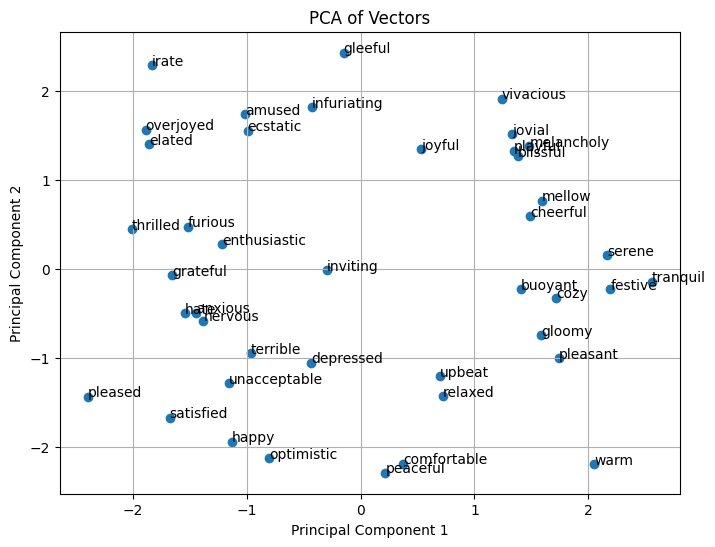

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

lexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

# print(lexicon_embedded)

# Convert dictionary values to a NumPy array
X = np.array(list(lexicon_embedded.values()))

# Apply PCA (keep top 2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o')

# Annotate points with dictionary keys
for i, key in enumerate(lexicon_embedded.keys()):
    plt.annotate(key, (X_pca[i, 0], X_pca[i, 1]))

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Vectors")
plt.grid()
plt.show()

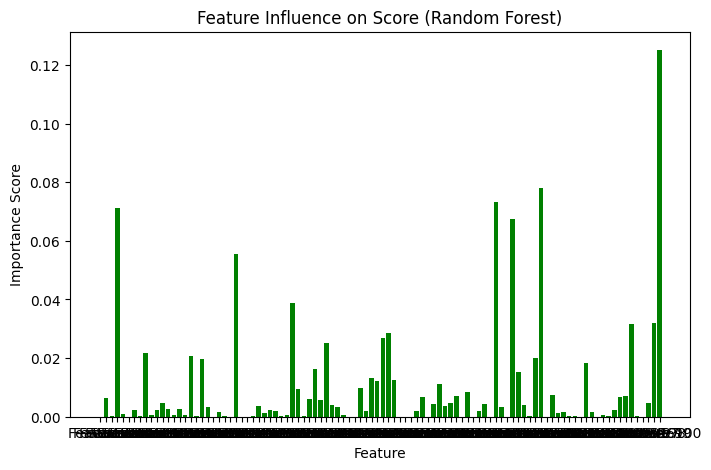

        Feature  Importance
99  Feature 100    0.125084
78   Feature 79    0.077901
70   Feature 71    0.073258
3     Feature 4    0.071192
73   Feature 74    0.067323
..          ...         ...
58   Feature 59    0.000000
53   Feature 54    0.000000
96   Feature 97    0.000000
23   Feature 24    0.000000
55   Feature 56    0.000000

[100 rows x 2 columns]


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd

vlexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

X = np.array(list(lexicon_embedded.values()))
y = np.array([v[0] for v in lexicon.values()])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances
importance_rf = rf.feature_importances_

feature_names = [f"Feature {i+1}" for i in range(X.shape[1])]

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(feature_names, importance_rf, color="green")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Influence on Score (Random Forest)")
plt.show()

# Print feature importance
feature_importance_rf = pd.DataFrame({"Feature": feature_names, "Importance": importance_rf})
print(feature_importance_rf.sort_values(by="Importance", ascending=False))


In [22]:
# Get indexes of features with importance > 0.04
important_feature_indexes = np.where(importance_rf > 0.04)[0]

# Print result
print("Indexes of most important features:", important_feature_indexes)

Indexes of most important features: [ 3 24 70 73 78 99]


In [23]:
lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    important_values = []
    for i in important_feature_indexes:
        important_values.append(adjectives_vectors[key][i])
    x_train.append(important_values)
    y_train.append([lexicon[key][0], 0])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

    # Train the model
model.fit(x_train, y_train)

for key in adjectives_vectors:
    important_values = []
    for i in important_feature_indexes:
        important_values.append(adjectives_vectors[key][i])
    result = model.predict([important_values])
    lexicon_trained[key][0] = result[0][0]

print(lexicon_trained)


{'abandoned': [0.5486681878355949, 0, 0, 0, 0, 0], 'able': [0.2786191329553097, 0, 0, 0, 0, 0], 'absolute': [0.4494940066117147, 0, 0, 0, 0, 0], 'adorable': [0.3354374792276974, 0, 0, 0, 0, 0], 'adventurous': [0.30175081906132595, 0, 0, 0, 0, 0], 'academic': [0.10654594475349505, 0, 0, 0, 0, 0], 'acceptable': [0.3548064934405259, 0, 0, 0, 0, 0], 'acclaimed': [0.3922733839885639, 0, 0, 0, 0, 0], 'accomplished': [0.1963125107184642, 0, 0, 0, 0, 0], 'accurate': [0.547483080029996, 0, 0, 0, 0, 0], 'aching': [0.33845299022230957, 0, 0, 0, 0, 0], 'acidic': [0.1982738853866666, 0, 0, 0, 0, 0], 'acrobatic': [0.5154008601164807, 0, 0, 0, 0, 0], 'active': [0.3241352180086809, 0, 0, 0, 0, 0], 'actual': [0.45078678809913375, 0, 0, 0, 0, 0], 'adept': [0.2946435975262478, 0, 0, 0, 0, 0], 'admirable': [0.14469432807441213, 0, 0, 0, 0, 0], 'admired': [0.2021639087087648, 0, 0, 0, 0, 0], 'adolescent': [0.36571922158766434, 0, 0, 0, 0, 0], 'adored': [0.36184108888195154, 0, 0, 0, 0, 0], 'advanced': [0.3

## All together, from the very beginning, one by one: important steps:

In [4]:
# imports section
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm
from gensim import corpora, models, similarities
import string

import gensim.downloader as api
from gensim.models import Word2Vec

import itertools

In [2]:
# vectorization example:
# Define the lexicon with mood vectors
moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}
moods_indeces = {y.lower(): x for x, y in moods.items()}

lexicon = {
    # "frustrated": [0.8, 0.4, 0.3, 0, 0, 0], 
    "anxious": [0.3, 0.9, 0.4, 0, 0, 0.1],
    # "disappointed": [0.5, 0.3, 0.8, 0.1, 0, 0], 
    "furious": [0.9, 0.3, 0.2, 0, 0, 0],
    "peaceful": [0, 0, 0, 1, 0.4, 0.2], 
    "hate": [0.9, 0.3, 0.3, 0, 0, 0],
    "joyful": [0, 0, 0, 0.2, 0.9, 0.7], 
    "unacceptable": [0.9, 0.6, 0.6, 0, 0, 0],
    "thrilled": [0, 0, 0, 0, 0.6, 1], 
    "infuriating": [0.9, 0.8, 0.6, 0, 0, 0],
    "irate": [0.9, 0.2, 0.1, 0, 0, 0], 
    "terrible": [0.9, 0.7, 0.7, 0, 0, 0],
    "nervous": [0.2, 0.8, 0.3, 0.1, 0, 0.2],
    "melancholy": [0.1, 0.4, 0.9, 0.2, 0, 0], 
    "depressed": [0.1, 0.1, 0.9, 0.2, 0, 0], 
    "gloomy": [0.1, 0.1, 0.8, 0.3, 0, 0], 
    "serene": [0, 0, 0, 0.9, 0.8, 0.9], 
    "elated": [0, 0, 0, 0.1, 0.8, 0.9],
    "ecstatic": [0, 0, 0, 0, 0.7, 1],
    "overjoyed": [0.1, 0.1, 0.1, 0.1, 1, 0.9],
    "gleeful": [0.1, 0.1, 0.1, 0.1, 0.9, 0.8],
    "cheerful": [0.1, 0.1, 0.1, 0.1, 0.8, 0.5],
    "optimistic": [0.1, 0.2, 0.1, 0.7, 0.8, 0.6],
    "buoyant": [0.1, 0.2, 0.1, 0.8, 0.7, 0.7],
    "enthusiastic": [0.2, 0.3, 0.1, 0.6, 0.8, 0.9],
    "upbeat": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7],
    "festive": [0.1, 0.1, 0.1, 0.7, 0.8, 0.7],
    "playful": [0.1, 0.2, 0.1, 0.6, 0.7, 0.8],
    "vivacious": [0.1, 0.2, 0.1, 0.6, 0.8, 0.7],
    "jovial": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7],
    "amused": [0.1, 0.2, 0.1, 0.6, 0.7, 0.7],
    "blissful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7],
    "grateful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7],
    "tranquil": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6],
    "relaxed": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6],
    "comfortable": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6],
    "cozy": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6],
    "warm": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6],
    "inviting": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "satisfied": [0.1, 0.1, 0.2, 0.6, 0.5, 0.3],
    "pleasant": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "pleased" : [0.1, 0.1, 0.1, 0.9, 0.8, 0.3], 
    "mellow": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6] , 
    "happy": [0.1, 0.1, 0.1, 0.7, 1, 0.6]
    }

In [6]:
# prepare data
# load corpus
corpus = api.load('glove-wiki-gigaword-100')
vector = corpus['computer']
# print(vector)

# read adjactives file
data = ''
with open('../resources/sets/english-adjectives.txt', 'r') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')
# print(adjectives[:20])


adjectives_vectors = {}

for adjective in adjectives:
    adjectives_vectors[adjective] = corpus[adjective]

for key, value in itertools.islice(adjectives_vectors.items(), 2):
    print(key, ":", value)

abandoned : [ 0.43756    0.22949   -0.24099    0.42471   -0.25692    0.073755
 -0.096612   0.46294    0.85405    0.30859    0.35545    0.81983
  0.20312   -0.1225     0.17376   -0.62581    0.48522    0.23915
 -0.24558   -0.11948    0.69671    0.57527    0.65548   -0.029388
 -0.19702   -0.4308    -0.77335   -0.5166    -0.201      0.48815
  0.23728    0.31009   -0.25274   -0.042121  -0.19871   -0.17874
  0.019558  -0.42301    0.0743    -0.073421  -0.57583   -0.30048
  0.64496   -0.071048   0.52107    0.17243   -0.13616    0.97539
  0.23503   -0.28925   -0.072434   0.10553    0.24934    0.82306
  0.21013   -1.7977    -0.54545   -0.29966    1.0294     0.16126
  0.081623   0.53188    0.20484    0.36831    0.7118    -0.23808
  0.16678   -0.16994   -0.56703   -0.22874   -0.042396  -0.0065193
  0.01364   -0.2084    -0.35861   -0.055815   0.16845    0.46759
 -0.9905     0.35124   -0.070496   0.20322   -0.20443    0.75299
 -0.70367    0.19664    0.045248  -0.044681  -0.95952    0.31755
 -0.11741

In [11]:
# dimensionality reduction via random forest feature extraction, svm in cycle for every component

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

for i in range(6):
    X = np.array(list(lexicon_embedded.values()))
    y = np.array([v[i] for v in lexicon.values()])

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)

    # Get feature importances
    importance_rf = rf.feature_importances_
    # Get indexes of features with importance > 0.04
    important_feature_indexes = np.where(importance_rf > 0.04)[0]

    # Print result
    print(f"Indexes of most important features for {i}:", important_feature_indexes)

    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
    model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

    x_train, y_train = [], []
    for key in lexicon.keys():
        important_values = []
        for j in important_feature_indexes:
            important_values.append(adjectives_vectors[key][j])
        x_train.append(important_values)
        y_train.append([lexicon[key][i], 0])

    x_train_np = np.array(x_train)
    y_train_np = np.array(y_train)

    # Train the model
    model.fit(x_train, y_train)

    for key in adjectives_vectors:
        important_values = []
        for j in important_feature_indexes:
            important_values.append(adjectives_vectors[key][j])
        result = model.predict([important_values])
        lexicon_trained[key][i] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 20):
    print(key, ":", value)

# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

Indexes of most important features for 0: [ 3 24 70 73 78 99]
Indexes of most important features for 1: [ 6 57 77]
Indexes of most important features for 2: [ 6 34 73 77 87]
Indexes of most important features for 3: [ 3  8 41 42]
Indexes of most important features for 4: [ 6  8 34 38 40 73 77]
Indexes of most important features for 5: [ 8 34 38 40 53]
abandoned : [0.5486681878355949, 0.47062416113222927, 0.38359808673471113, 0.4588480317556811, 0.12163844934457307, 0.09957475052909831]
able : [0.2786191329553097, 0.20262337156979324, 0.06466568285103341, 0.23724384453675024, 0.6747227093815318, 0.2966139232023028]
absolute : [0.4494940066117147, 0.33378779337734676, 0.31559845033282263, 0.6490652162333584, 0.5129485212228615, 0.5090630856701435]
adorable : [0.3354374792276974, 0.0666724772120803, 0.158594782851804, 0.10601693686709868, 0.65561091839924, 0.7573534050125633]
adventurous : [0.30175081906132595, 0.19666645918428138, 0.22543710150172871, 0.2644411066144988, 0.54807839476016

**TODO**:

1. cross-validation, fine tuning
2. Find political data, find more words!
3. fuzzy logic rule generation! (may be via evolut. algorithms)
4. apply fl rules
5. results!